In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import griddata
from KT_model import *
from SpecRep import SRM, getSww_from_a_model
from utils import EPSD_show, simple_interpol2d

In [2]:
# %matplotlib widget

In this file, I'll learn how to obtain the EPSD from a real earthquake acceleratioin recording by STFT

In [3]:
# import the El centro signal

col_names_NS = ['time', 'NS']

df_NS = pd.read_table('/Users/leslie/Google Drive/Paper Paper Paper/proposed_papers_PhD_UoL/By topic/[Project] Missing data imputation in incomlete ground motion/Time domain method/Playtoy_data/El centro earthquake data/elcentro_NS.dat', 
                   delimiter=' ', names=col_names_NS)

In [4]:
t_axis = df_NS['time']
amp_axis = df_NS['NS']

In [5]:
FS = int(1 / (t_axis[3] - t_axis[2]))

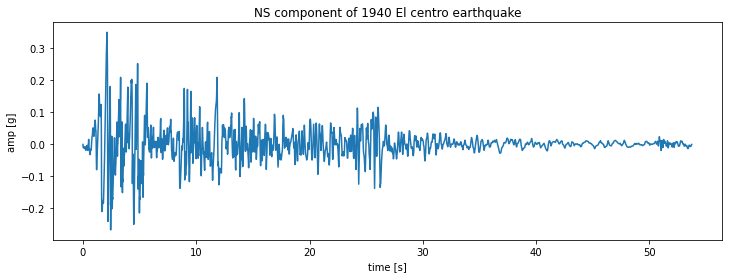

In [6]:
plt.figure(figsize=(12, 4))
plt.plot(t_axis, amp_axis)
plt.title('NS component of 1940 El centro earthquake')
plt.xlabel('time [s]')
plt.ylabel('amp [g]')
plt.show()

#### Using `signal.stft`

In [ ]:
f, t, Zxx = signal.stft(amp_axis, FS, nperseg=128)

In [ ]:
f.shape

In [ ]:
t.shape

In [ ]:
Zxx.shape

Number of frequency bins = $\frac{framesize}{2}+1$.

Ergo, apparantly, the long the 'framesize', i.e. `nperseg`, the more frequency bins, the higher the frequency resolution;

In [ ]:
128/2+1

Number of frames = $\frac{samples - framesize}{hopsize}+1$

In [ ]:
(len(amp_axis)-128)/64 + 1

In [ ]:
# t

In [ ]:
# t_axis

Hint: so the the new time resolution is: `dt` = 1.28s

In [ ]:
# as a comparison, see the t_axis of the original signal, dt=0.02s

In [ ]:
f, t, Zxx = signal.stft(amp_axis, FS, nperseg = 256)

In [ ]:
Zxx.shape

In [ ]:
plt.pcolormesh(t, f, np.abs(Zxx), cmap='viridis', shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
t

### Using `plt.specgram`

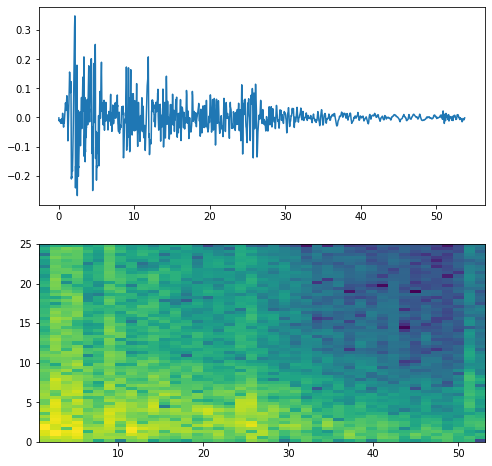

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8,8))
ax1.plot(t_axis, amp_axis)
Pxx, freqs, t_bins, im = ax2.specgram(amp_axis, 
                                      NFFT =128,
                                      Fs=FS, 
                                      noverlap=64,
                                      mode='psd')
plt.show()

In [8]:
Pxx.shape

(65, 41)

In [9]:
freqs.shape

(65,)

In [ ]:
# For 2D representation

In [ ]:
# import matplotlib
# fig = plt.figure(figsize=(6,4))

# # nnormalize_instance = matplotlib.colors.Normalize()

# plt.pcolormesh(t_bins, freqs, Pxx, vmin=0, vmax=np.max(Pxx), shading='nearest', cmap='coolwarm')
# plt.colorbar()
# plt.xlabel('time (s)')
# plt.ylabel('freq (HZ)')
# # plt.grid()
# plt.title(r'$S_{wt}$')
# plt.show()

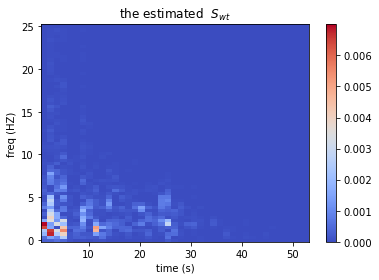

In [36]:
EPSD_show(Pxx, freqs, t_bins, format='2d')

> 3D EPSD plot

In [ ]:
EPSD_show(Pxx, freqs, t_bins, format='3d')

### Doing 2D interpolation

In [10]:
# Points, values, and then new coordinates
import itertools
points = list(itertools.product(t_bins, freqs))

sample_df = pd.DataFrame()
sample_df['X'] = [xy[0] for xy in points]
sample_df['Y'] = [xy[1] for xy in points]
# sample_df['value'] = values

In [11]:
up_reversed = np.flipud(Pxx)
values = np.ravel(up_reversed, order='F')

In [12]:
x_min, x_max = 0.0, sample_df['X'].max()
y_min, y_max = 0.0, sample_df['Y'].max()

In [13]:
new_x_coord = np.linspace(x_min, x_max, 2500)
new_y_coord = np.linspace(y_min, y_max, 1024)

In [14]:
new_x_coord

array([0.00000000e+00, 2.10004002e-02, 4.20008003e-02, ...,
       5.24379992e+01, 5.24589996e+01, 5.24800000e+01])

In [15]:
new_y_coord

array([0.00000000e+00, 2.44379277e-02, 4.88758553e-02, ...,
       2.49511241e+01, 2.49755621e+01, 2.50000000e+01])

In [16]:
xx, yy = np.meshgrid(new_x_coord, new_y_coord)

In [17]:

grid_z0 = griddata(points, values, xi=(xx, yy), method='nearest')

In [21]:
grid_z1 = np.flipud(grid_z0)

In [22]:
# grid_z0 = simple_interpol2d(Pxx, freqs, t_bins)

In [23]:
grid_z1.shape

(1024, 2500)

*a 2D representation*

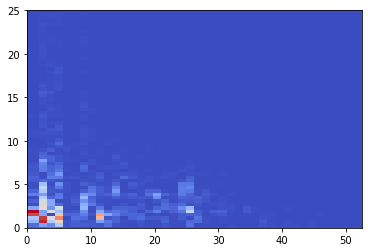

In [24]:
# EPSD_show(grid_z0, xx, yy, format='2d')

plt.pcolormesh(new_x_coord,
               new_y_coord,
               grid_z1, 
               vmin=0, 
               vmax=np.max(Pxx), 
               shading='nearest', 
               cmap='coolwarm')

*a 3D represnetaiton*

In [ ]:
# grid_z0[0, :] == grid_z0[5, :]

In [ ]:
# plt.figure(figsize=(10, 10))
# plt.imshow(grid_z0)

In [ ]:
# X, Y = np.meshgrid(t_bins, freqs)
# Z = Pxx

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, grid_z0, cmap='viridis')
ax.set_title('plot surface');

> Since we already have the STFT, we try the **SRM**

*let's try directly do simulation based on the estimated spectra*

In [26]:
from_esti_instance = SRM(wu=25 * np.pi, 
                         N1=1024, 
                         fs=50, 
                         duration=50)

In [27]:
# Take a look at the shape
print("the shape of the w axis:", from_esti_instance.w_axis_4simu.shape)
print("the shape of the time axis:", from_esti_instance.t_axis_4simu.shape)

the shape of the w axis: (1024,)
the shape of the time axis: (2500,)


In [28]:

# we already got the estimated spectra, ie. Pxx

the lower limit of sampling frequency: 25
the length of the simulation (2500,)


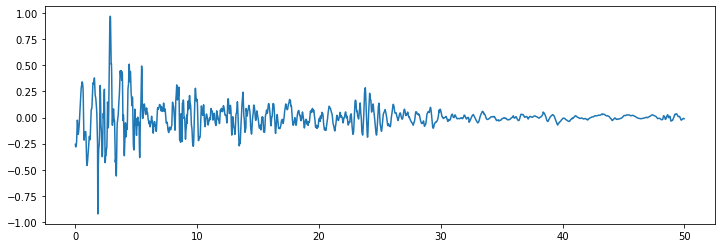

In [38]:
# try method3
fig = plt.figure(figsize=(12, 4))
a_simulation = from_esti_instance.SpecRepsentation(grid_z1, plot='y')

In [ ]:
# a_simulation = from_esti_instance.SpecRepsentation2(Pxx, t_bins=t_bins, freqs=freqs, plot='y')

## Import another real recording

In [ ]:
ESM_path='/Users/leslie/Documents/GitHub_repos/ImputeIntervalGM/1the target accelerogram/ESM_test3/IT.ACC.00.HGN.D.EMSC-20161030_0000029.ACC.MP.ASC'

In [ ]:
acc_tg = np.loadtxt(ESM_path, skiprows=64)

In [ ]:
acc_tg.shape

In [ ]:
t_axis = np.arange(0, len(acc_tg)*0.005, 0.005)

In [ ]:
t_axis.shape

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8, 8))
ax1.plot(t_axis, acc_tg)
Pxx, freqs, t_bins, im = ax2.specgram(acc_tg, 
                                      NFFT = 128,
                                      Fs=200, 
                                      noverlap=64,
                                      mode='psd')
plt.show()

In [ ]:
Pxx.shape

In [ ]:
from_esti_instance = SRM(wu=25 * 2 * np.pi, 
                         N1=1024, 
                         fs=200, 
                         duration=35)

In [ ]:
# Take a look at the shape
print("the shape of the w axis:", from_esti_instance.w_axis_4simu.shape)
print("the shape of the time axis:", from_esti_instance.t_axis_4simu.shape)

In [ ]:
# try method3
a_simulation = from_esti_instance.SpecRepsentation3(Pxx, t_bins=t_bins, plot='y')

In [ ]:
freqs.shape